In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
app_test = pd.read_csv("/content/drive/My Drive/FDS/application_test.csv")
app_train = pd.read_csv("/content/drive/My Drive/FDS/application_train.csv")
bureau=pd.read_csv("//content/drive/My Drive/FDS/bureau.csv")
samp_sub=pd.read_csv("/content/drive/My Drive/FDS/sample_submission.csv")
br_bal=pd.read_csv("/content/drive/My Drive/FDS/bureau_balance.csv")
ccb=pd.read_csv("/content/drive/My Drive/FDS/credit_card_balance.csv")
prev_appl=pd.read_csv("/content/drive/My Drive/FDS/previous_application.csv")
pos=pd.read_csv("/content/drive/My Drive/FDS/POS_CASH_balance.csv")
inp=pd.read_csv("/content/drive/My Drive/FDS/installments_payments.csv")

##Exploratory Data Analysis

###Missing value and the plot for the dataset

In [ ]:
# Examine the missing values.
# Please note, we will just check the information on the missing values. 
# We will not remove any column as of now because we don't know which column is going to be important in future.
# Function to detect missing values.
def missing_info(dataframe):
    total=dataframe.isnull().sum()
  # standardised score of the missing values:
    mean_null=sum(total)/len(dataframe.columns)
    var_null=sum(((total-mean_null)**2))/len(dataframe.columns)
    metric=((total-mean_null)/var_null)*1000000
  # Percentage of missing value
    percent = (dataframe.isnull().sum()/dataframe.isnull().count()*100)
  # Make a table with the results
    result=pd.concat([total,metric, percent],axis=1)
    result.columns=["count","standardised_score", "percentage"]
    result=result[result.iloc[:,1] != 0].sort_values(
          'count', ascending=False).round(2)
    result= result[result["percentage"] > 0]
    f,ax =plt.subplots(figsize=(15,10))
    plt.xticks(rotation='90')
    fig=sns.barplot(result.index, result["percentage"], color="red",alpha=0.8)
    plt.xlabel('Features')
    plt.ylabel('Percentage of missing values')
    plt.title('Percentage of missing data by feature')
    return(result.head())

,count,standardised_score,percentage
COMMONAREA_MEDI,214865,18.43,69.87
COMMONAREA_AVG,214865,18.43,69.87
COMMONAREA_MODE,214865,18.43,69.87
NONLIVINGAPARTMENTS_MODE,213514,18.25,69.43
NONLIVINGAPARTMENTS_AVG,213514,18.25,69.43


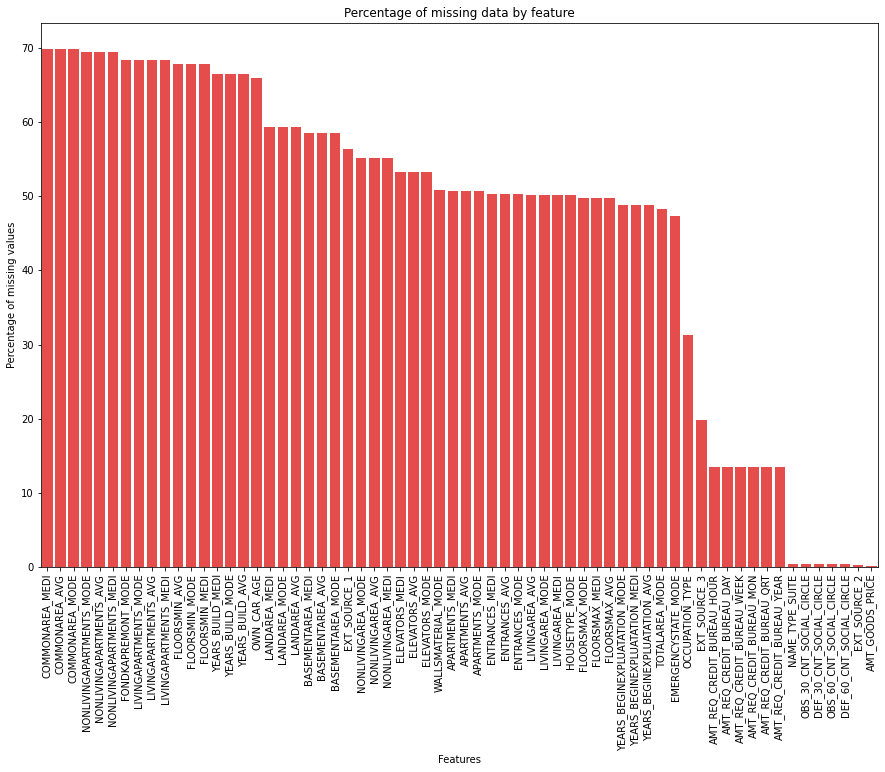

In [ ]:
missing_info(app_train)

,count,standardised_score,percentage
COMMONAREA_AVG,33495,120.87,68.72
COMMONAREA_MODE,33495,120.87,68.72
COMMONAREA_MEDI,33495,120.87,68.72
NONLIVINGAPARTMENTS_AVG,33347,120.05,68.41
NONLIVINGAPARTMENTS_MODE,33347,120.05,68.41
...,...,...,...
OBS_30_CNT_SOCIAL_CIRCLE,29,-63.93,0.06
OBS_60_CNT_SOCIAL_CIRCLE,29,-63.93,0.06
DEF_60_CNT_SOCIAL_CIRCLE,29,-63.93,0.06
AMT_ANNUITY,24,-63.96,0.05


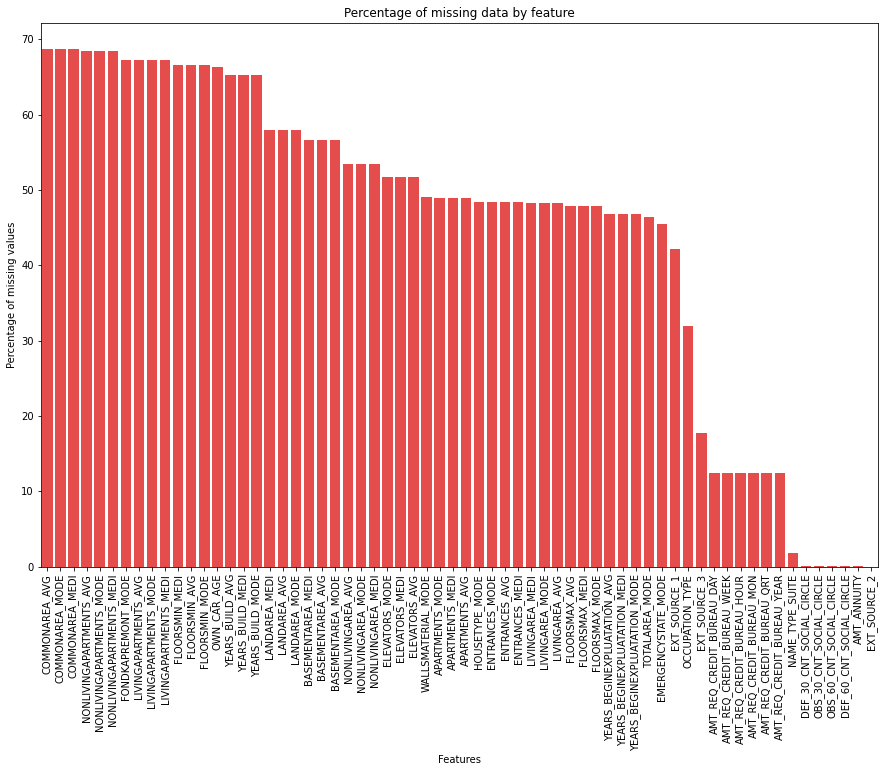

In [ ]:
missing_info(app_test)

,count,standardised_score,percentage
AMT_ANNUITY,1226791,6.30,71.47
AMT_CREDIT_MAX_OVERDUE,1124488,5.65,65.51
DAYS_ENDDATE_FACT,633653,2.54,36.92
AMT_CREDIT_SUM_LIMIT,591780,2.28,34.48
AMT_CREDIT_SUM_DEBT,257669,0.16,15.01
DAYS_CREDIT_ENDDATE,105553,-0.80,6.15


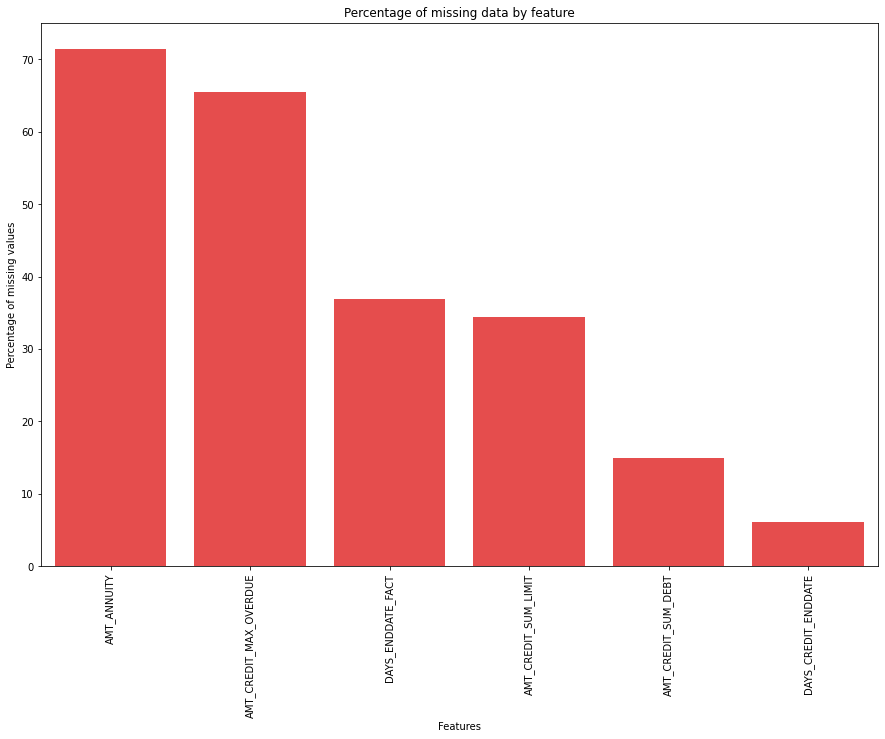

In [ ]:
missing_info(bureau)

,count,standardised_score,percentage
AMT_PAYMENT_CURRENT,767988,4.45,20.00
AMT_DRAWINGS_ATM_CURRENT,749816,4.29,19.52
CNT_DRAWINGS_POS_CURRENT,749816,4.29,19.52
AMT_DRAWINGS_OTHER_CURRENT,749816,4.29,19.52
AMT_DRAWINGS_POS_CURRENT,749816,4.29,19.52
CNT_DRAWINGS_OTHER_CURRENT,749816,4.29,19.52
CNT_DRAWINGS_ATM_CURRENT,749816,4.29,19.52
CNT_INSTALMENT_MATURE_CUM,305236,0.43,7.95
AMT_INST_MIN_REGULARITY,305236,0.43,7.95


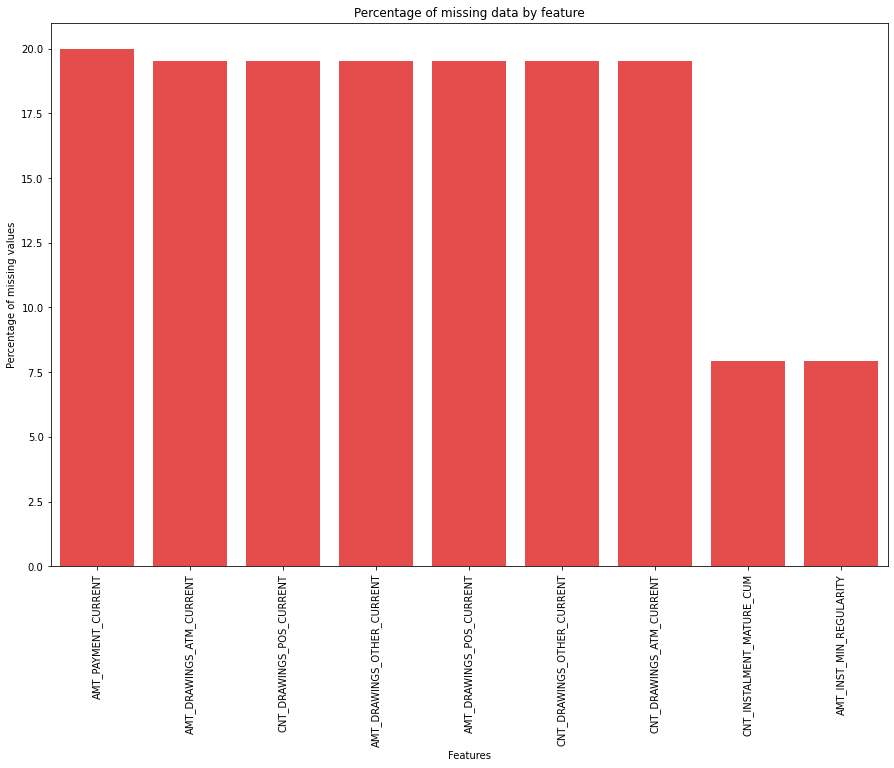

In [ ]:
missing_info(ccb)

,count,standardised_score,percentage
RATE_INTEREST_PRIVILEGED,1664263,6.62,99.64
RATE_INTEREST_PRIMARY,1664263,6.62,99.64
AMT_DOWN_PAYMENT,895844,2.89,53.64
RATE_DOWN_PAYMENT,895844,2.89,53.64
NAME_TYPE_SUITE,820405,2.52,49.12
NFLAG_INSURED_ON_APPROVAL,673065,1.81,40.30
DAYS_TERMINATION,673065,1.81,40.30
DAYS_LAST_DUE,673065,1.81,40.30
DAYS_LAST_DUE_1ST_VERSION,673065,1.81,40.30
DAYS_FIRST_DUE,673065,1.81,40.30


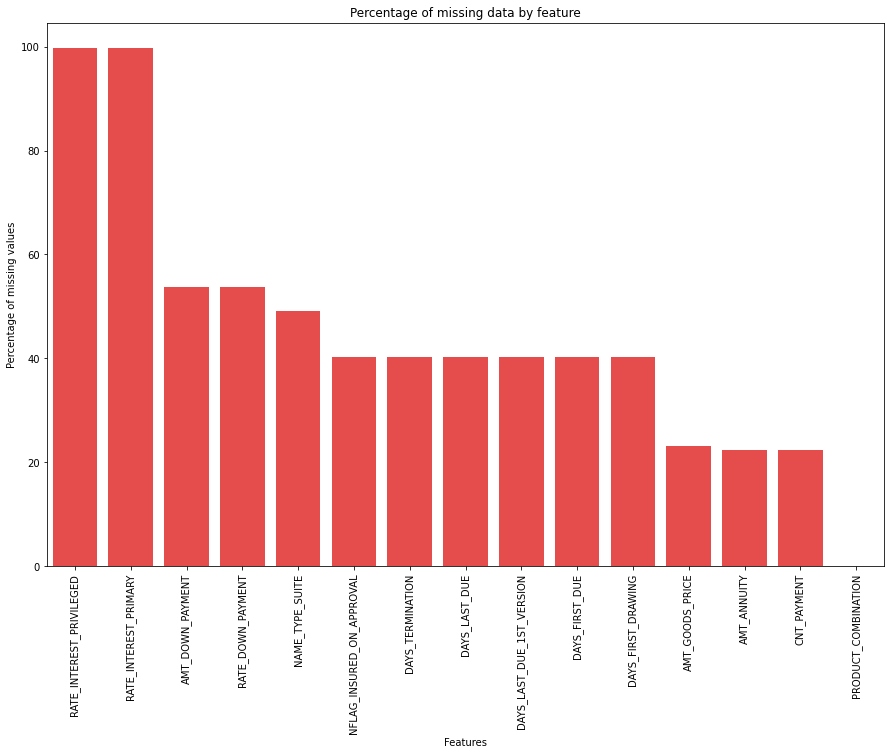

In [ ]:
missing_info(prev_appl)

,count,standardised_score,percentage
CNT_INSTALMENT_FUTURE,26087,153.44,0.26
CNT_INSTALMENT,26071,153.32,0.26


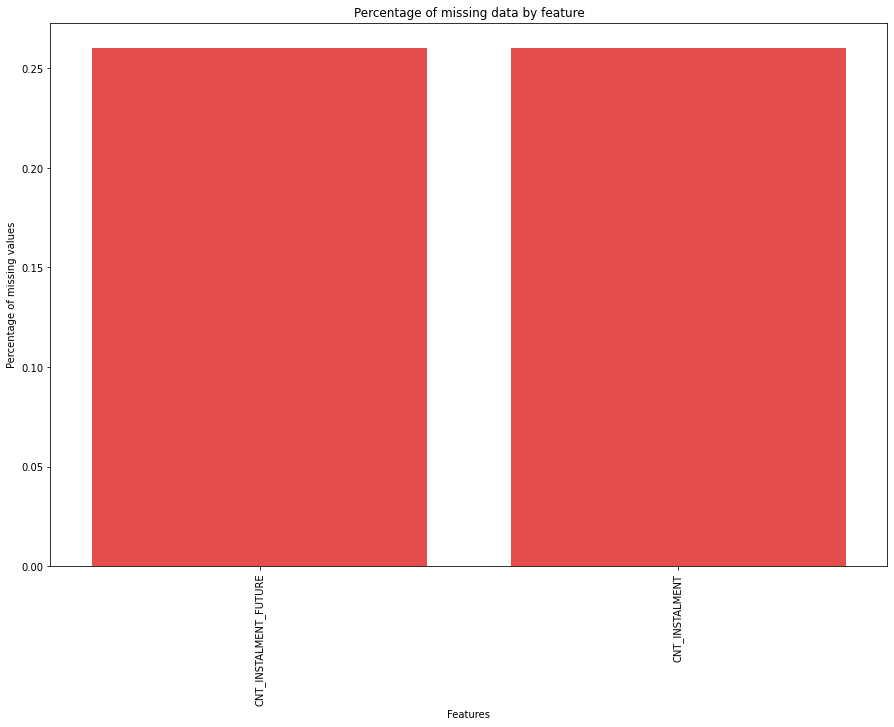

In [ ]:
missing_info(pos)

,count,standardised_score,percentage
DAYS_ENTRY_PAYMENT,2905,1376.94,0.02
AMT_PAYMENT,2905,1376.94,0.02


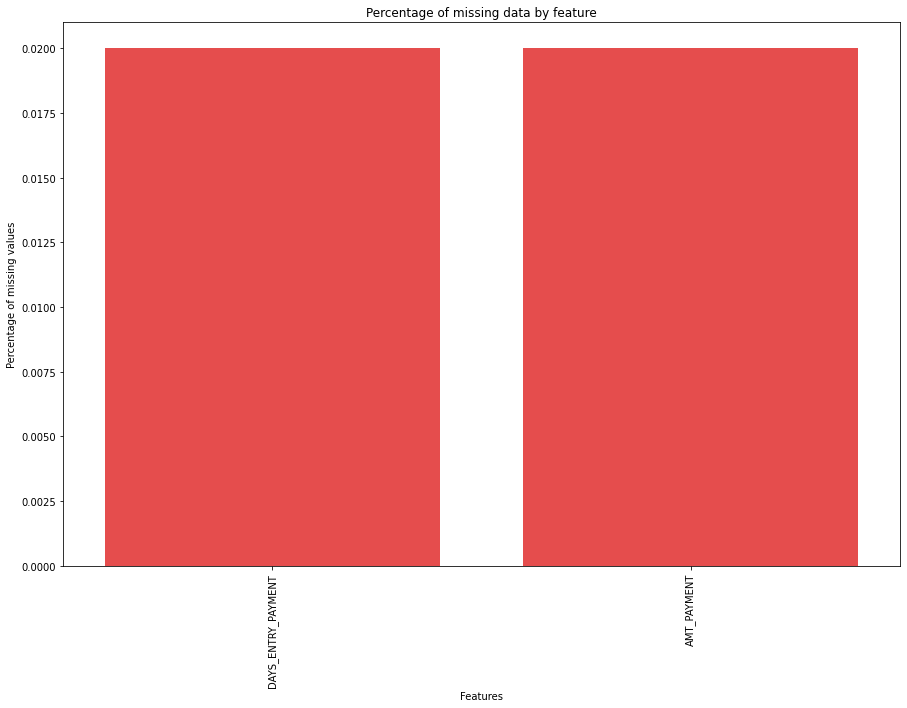

In [ ]:
missing_info(inp)

###Column types of all dataset

In [ ]:
# The first hurdle we face is due to the columns with several categories. So, first we have to encode those columns to proceed further.
# Before that, let's have a look at the column types of the data sets.

#################### Function to check the column types #######################
def coltyp(dataframe):
    type=dataframe.dtypes.value_counts()
  #we will see number of unique categories for each object
    cat= dataframe.select_dtypes('object').apply(pd.Series.nunique,axis=0)
    print(type)
    return cat

In [ ]:
coltyp(app_train)

float64    65
int64      41
object     16
dtype: int64


NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [ ]:
coltyp(app_test)

float64    65
int64      40
object     16
dtype: int64


NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               7
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             5
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [ ]:
coltyp(bureau)

float64    8
int64      6
object     3
dtype: int64


CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

In [ ]:
coltyp(br_bal)

int64     2
object    1
dtype: int64


STATUS    8
dtype: int64

In [ ]:
coltyp(samp_sub)

int64      1
float64    1
dtype: int64


Series([], dtype: float64)

In [ ]:
coltyp(ccb)

float64    15
int64       7
object      1
dtype: int64


NAME_CONTRACT_STATUS    7
dtype: int64

In [ ]:
coltyp(prev_appl)

object     16
float64    15
int64       6
dtype: int64


NAME_CONTRACT_TYPE              4
WEEKDAY_APPR_PROCESS_START      7
FLAG_LAST_APPL_PER_CONTRACT     2
NAME_CASH_LOAN_PURPOSE         25
NAME_CONTRACT_STATUS            4
NAME_PAYMENT_TYPE               4
CODE_REJECT_REASON              9
NAME_TYPE_SUITE                 7
NAME_CLIENT_TYPE                4
NAME_GOODS_CATEGORY            28
NAME_PORTFOLIO                  5
NAME_PRODUCT_TYPE               3
CHANNEL_TYPE                    8
NAME_SELLER_INDUSTRY           11
NAME_YIELD_GROUP                5
PRODUCT_COMBINATION            17
dtype: int64

In [ ]:
coltyp(pos)

int64      5
float64    2
object     1
dtype: int64


NAME_CONTRACT_STATUS    9
dtype: int64

In [ ]:
coltyp(inp)

float64    5
int64      3
dtype: int64


Series([], dtype: float64)

###More examination on train and test dataset

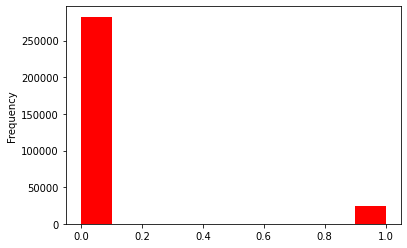

In [ ]:
app_train['TARGET'].astype(int).plot.hist(color = 'red')

In [3]:
selected_train_column =app_train[['TARGET','DAYS_EMPLOYED', 'DAYS_BIRTH', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', "CNT_FAM_MEMBERS", "CNT_CHILDREN", "EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3"]]
selected_test_column = app_test [['DAYS_EMPLOYED', 'DAYS_BIRTH', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL']]

Plotting histogram on Target against some selected features

In [ ]:
def distributions(dataset, target_variable, selected_variable):
    dataset_0 = dataset[dataset[target_variable] == 0]
    dataset_1 = dataset[dataset[target_variable] == 1]
    for variables in selected_variable:
        _, figure = plt.subplots(1, 2, figsize = (20, 5), sharex = True)
        figure[0].set_title("TARGET 0")
        figure[1].set_title("TARGET 1")
        sns.distplot(dataset_0[variables].dropna(), ax = figure[0], kde = False)
        sns.distplot(dataset_1[variables].dropna(), ax = figure[1], kde = False, color = "g")

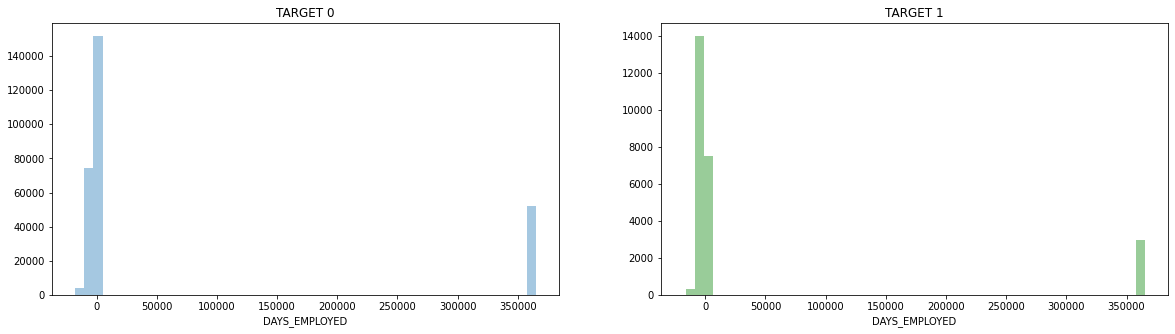

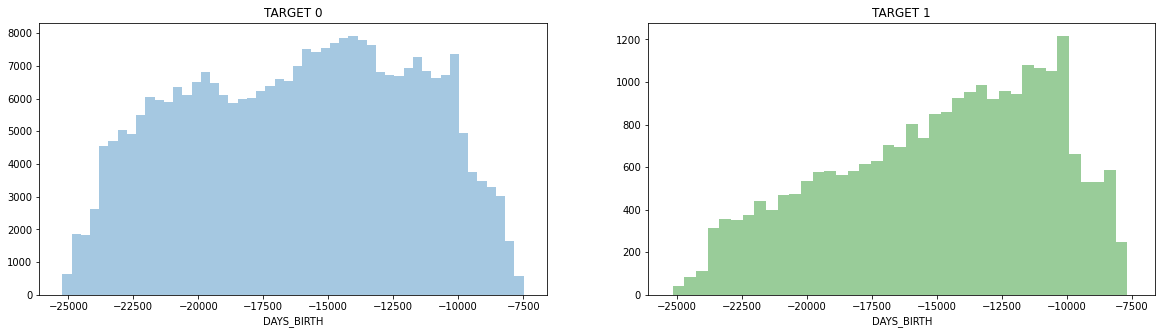

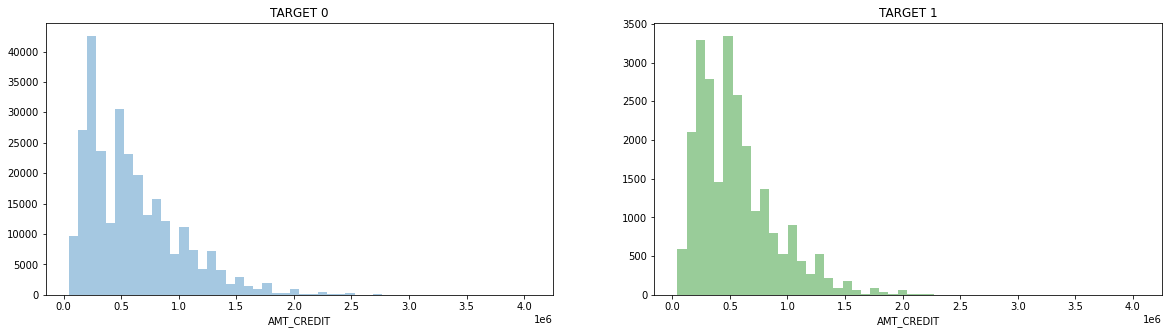

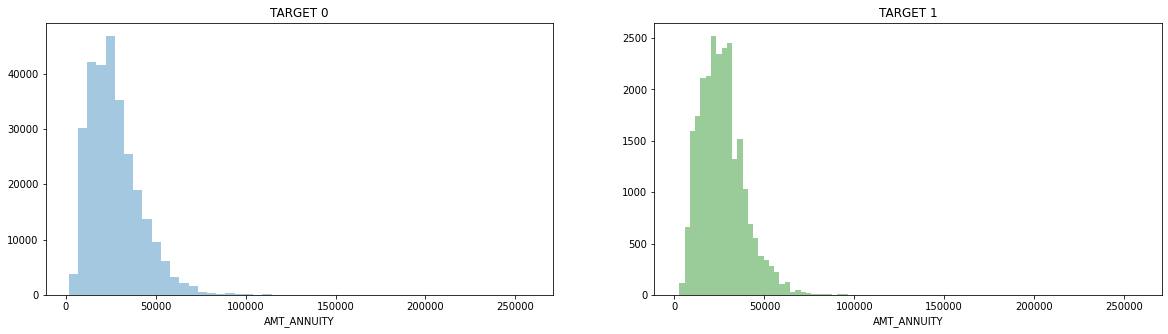

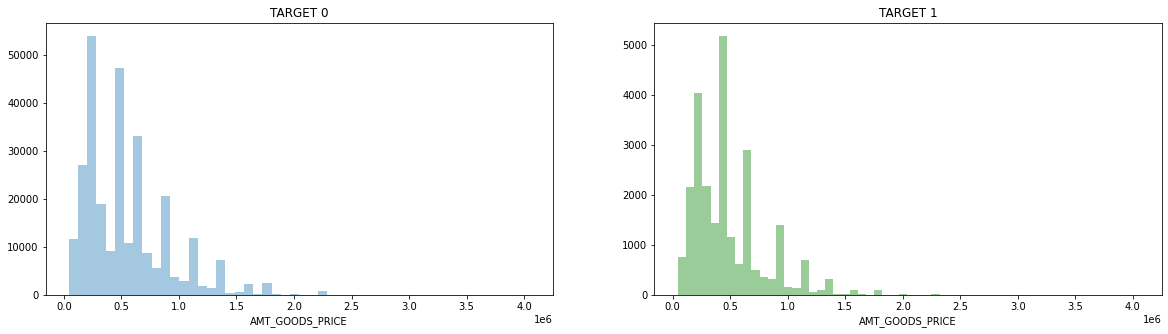

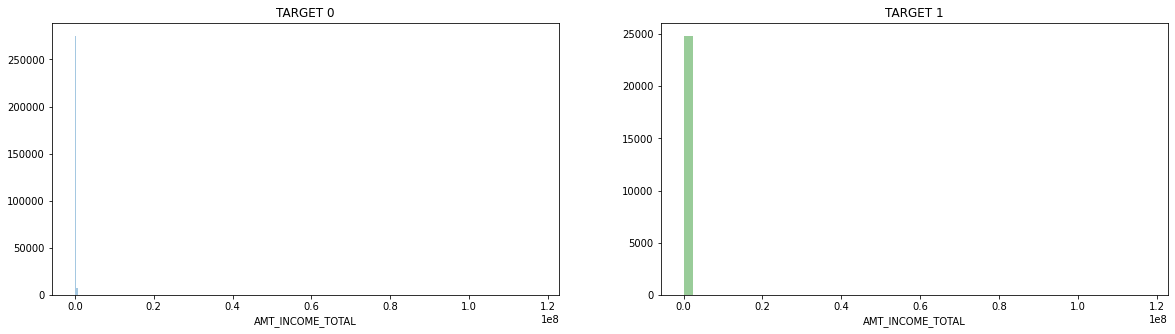

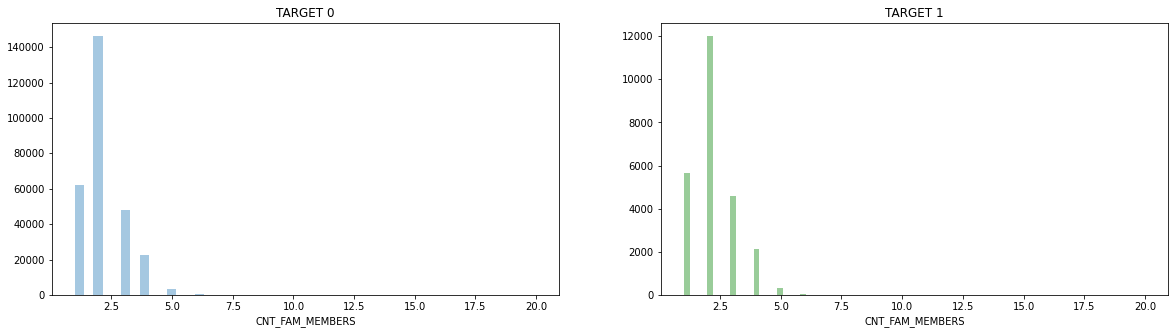

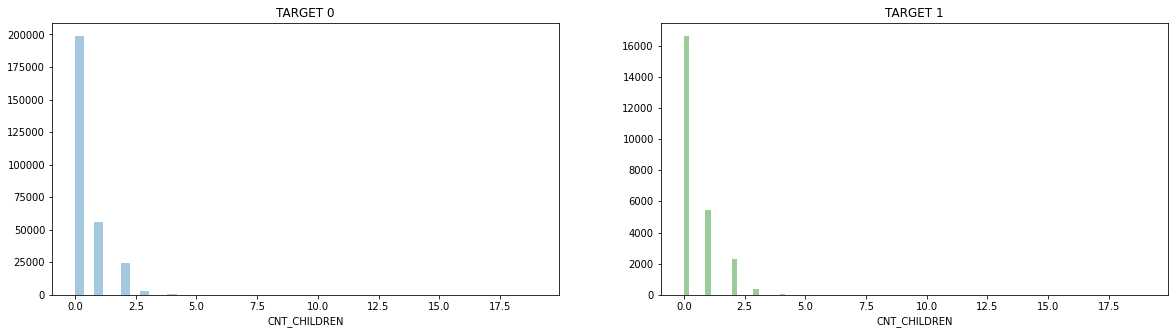

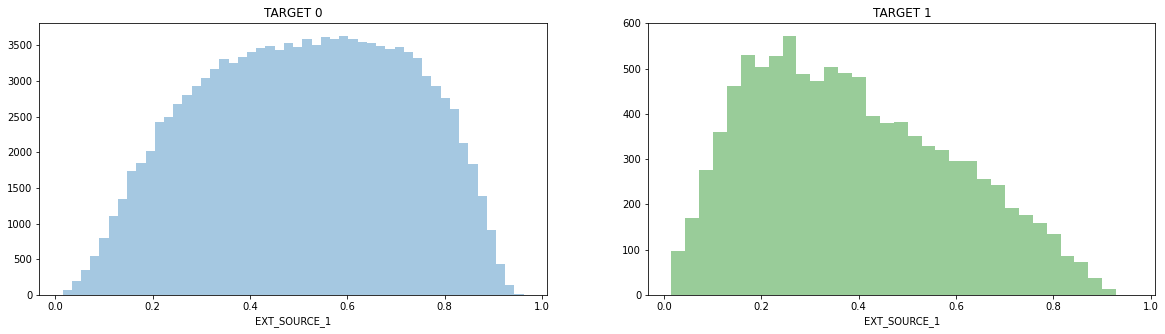

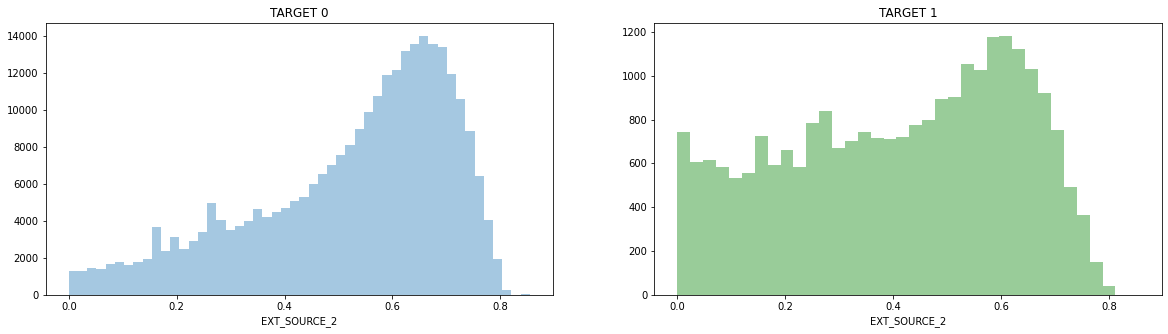

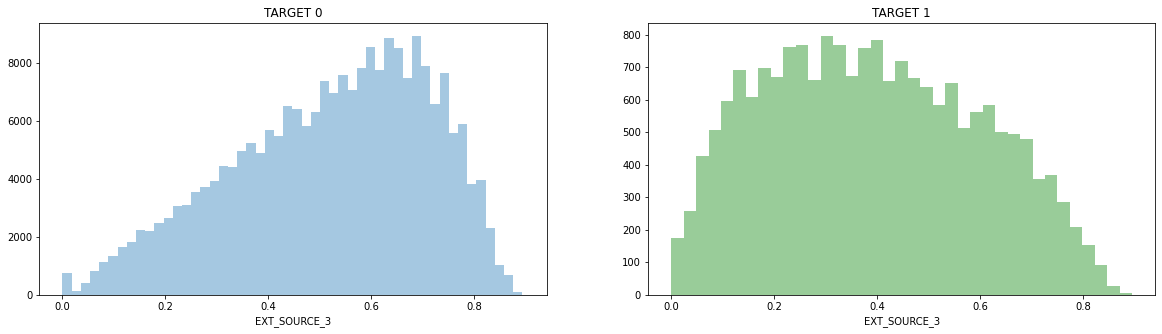

In [ ]:
distributions(app_train, "TARGET", selected_train_column.iloc[:,1:])

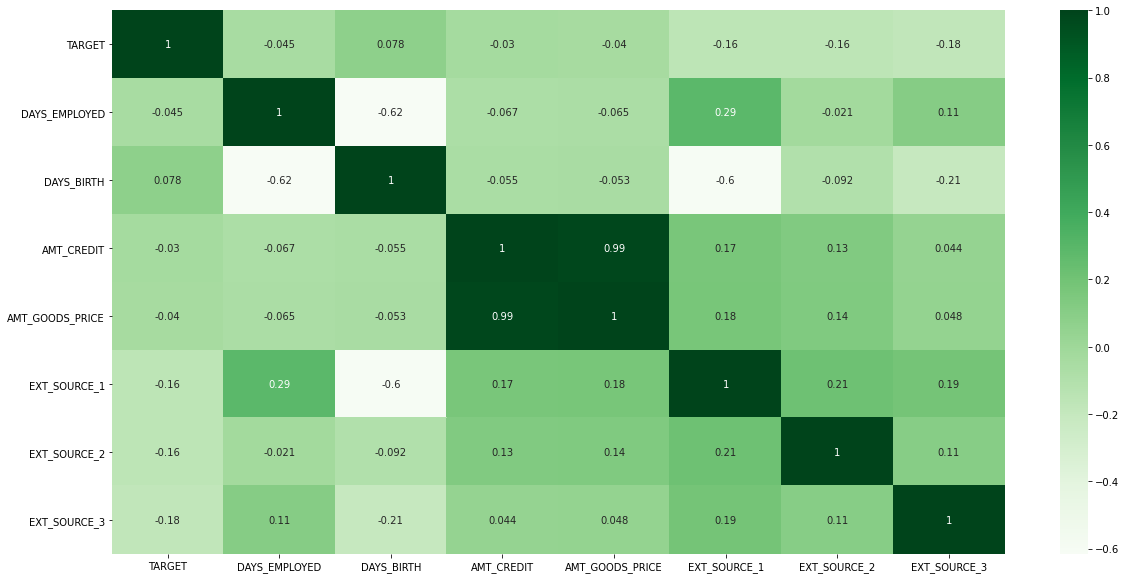

In [ ]:
# most correlated features
corrmat = selected_train_column.corr()
top_corr_features = corrmat.index[abs(corrmat['TARGET'])>=0.03]
plt.figure(figsize=(20,10))
g = sns.heatmap(selected_train_column[top_corr_features].corr(),annot=True,cmap="Greens")

In [4]:
feature_train = pd.DataFrame()
feature_train['employee_birth_ratio'] = selected_train_column.iloc[:,1] /selected_train_column.iloc[:,2]

feature_train['annuity_credit_ratio'] = selected_train_column.iloc[:,3] / selected_train_column.iloc[:,4]

feature_train['goods_credit_ratio'] = selected_train_column.iloc[:,3] / selected_train_column.iloc[:,5]

feature_train['Credit_to_Income_Ratio'] = selected_train_column.iloc[:,3] /  selected_train_column.iloc[:,6]

app_train=pd.concat([app_train,feature_train],axis=1)

In [5]:
feature_test = pd.DataFrame()
feature_test['employee_birth_ratio'] = selected_test_column.iloc[:,0] /selected_test_column.iloc[:,1]

feature_test['annuity_credit_ratio'] = selected_test_column.iloc[:,2] / selected_test_column.iloc[:,3]

feature_test['goods_credit_ratio'] = selected_test_column.iloc[:,2] / selected_test_column.iloc[:,4]

feature_test['Credit_to_Income_Ratio'] = selected_test_column.iloc[:,2] /  selected_test_column.iloc[:,5]

app_test=pd.concat([app_test,feature_test],axis=1)

In [6]:
# Now we have to conduct the one hot encoding:
def onehot(dataframe):
    df=pd.get_dummies(dataframe)
    print(df.shape)
    return(df)

In [7]:
app_train=onehot(app_train)

(307511, 250)


In [8]:
app_test = onehot(app_test)

(48744, 246)


In [9]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(app_train)
app_train.loc[:]=imputer.transform(app_train)

In [10]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(app_test)
app_test.loc[:]=imputer.transform(app_test)

In [11]:
app_train_target = app_train['TARGET']
app_train, app_test = app_train.align(app_test,join='inner',axis=1)
print('Training dataset shape: ', app_train.shape)
print('Testing dataset shape: ',app_test.shape)
app_train['TARGET'] = app_train_target

Training dataset shape:  (307511, 246)
Testing dataset shape:  (48744, 246)


#Working with bureau_balance and bureau dataset

In [ ]:
br_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


Counting the values of all the status:\
C = Closed\
X = Status unknown\
0 = Current status, no delay\
1 = 1 month delay\
2 = 2 month delay\
3 = 3 month delay\
4 = 4 month delay


In [ ]:
br_bal.STATUS.value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

Grouping the status with respect to the SK_ID_BUREAU of bureau_balance and then using unstack method to reshape the dataset formed by grouping. Some more columns are added by calculating the size, minimum and maximum value with respect to "SK_ID_BUREAU" using groupby function. Then the obtained unstack data is merged with bureau dataset.

In [12]:
bureau_counts = br_bal.groupby('SK_ID_BUREAU')['STATUS'].value_counts(normalize = False)
bureau_counts_unstacked = bureau_counts.unstack('STATUS')

In [13]:
bureau_counts_unstacked.columns = ['STATUS_0', 'STATUS_1','STATUS_2','STATUS_3','STATUS_4','STATUS_5','STATUS_C','STATUS_X',]
bureau_counts_unstacked['MONTHS_COUNT'] = br_bal.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].size()
bureau_counts_unstacked['MONTHS_MIN'] = br_bal.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].min()
bureau_counts_unstacked['MONTHS_MAX'] = br_bal.groupby('SK_ID_BUREAU')['MONTHS_BALANCE'].max()

In [14]:
bureau = bureau.join(bureau_counts_unstacked, how='left', on='SK_ID_BUREAU')

In [ ]:
bureau.shape

(1716428, 28)

In [ ]:
coltyp(bureau)

float64    19
int64       6
object      3
dtype: int64


CREDIT_ACTIVE       4
CREDIT_CURRENCY     4
CREDIT_TYPE        15
dtype: int64

In [15]:
bureau=onehot(bureau)

(1716428, 48)


Further bureau dataset has been grouped by "SK_ID_CURR" and obtained the average. We can drop the "SK_ID_BUREAU" as the unique id "SK_ID_CURR" is enough to identify the corresponding values.

In [16]:
bureau_avg = bureau.groupby('SK_ID_CURR').mean()
bureau_avg['bureau_count'] = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_BUREAU']
del bureau_avg['SK_ID_BUREAU']

#Working with previous_application

In [ ]:
prev_appl.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Featuring using One-Hot-Encoding and applying groupby function to count and finding average

In [17]:
prev_appl = onehot(prev_appl)

(1670214, 164)


In [18]:
prev_appl_avg = prev_appl.groupby('SK_ID_CURR').mean()
prev_appl_count = prev_appl[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
prev_appl_avg['nb_app'] = prev_appl_count['SK_ID_PREV']
del prev_appl_avg['SK_ID_PREV']

#Working with POS_CASH_Balance

In [ ]:
pos.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
pos.NAME_CONTRACT_STATUS.value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

In [19]:
le = LabelEncoder()
pos['NAME_CONTRACT_STATUS'] = le.fit_transform(pos['NAME_CONTRACT_STATUS'].astype(str))
pos['UNIQUE_STATUS_COUNT'] = pos[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()['NAME_CONTRACT_STATUS']
pos['UNIQUE_STATUS_MAX'] = pos[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()['NAME_CONTRACT_STATUS']
pos.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)
pos_average=pos.groupby('SK_ID_CURR').mean()

#Working with credit_card_balance

In [ ]:
ccb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [20]:
ccb['NAME_CONTRACT_STATUS'] = le.fit_transform(ccb['NAME_CONTRACT_STATUS'].astype(str))
ccb['UNIQUE_STATUS_COUNT'] = ccb[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby("SK_ID_CURR").nunique()["NAME_CONTRACT_STATUS"]
ccb['UNIQUE_STATUS2_MAX'] = ccb[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').max()
ccb.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)
ccb_average = ccb.groupby('SK_ID_CURR').mean()

#Working with installments_payments

In [ ]:
inp.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [21]:
inp_avg = inp.groupby('SK_ID_CURR').mean()
inp_max = inp.groupby('SK_ID_CURR').max()
inp_min = inp.groupby('SK_ID_CURR').min()
del inp_avg['SK_ID_PREV']

In [22]:
app_train = app_train.merge(right=prev_appl_avg.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=prev_appl_avg.reset_index(), how='left', on='SK_ID_CURR')

In [23]:
app_train = app_train.merge(right = bureau_avg.reset_index(), how="left", on="SK_ID_CURR")
app_test = app_test.merge(right = bureau_avg.reset_index(), how = "left", on="SK_ID_CURR")

In [24]:
app_train = app_train.merge(pos_average.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(pos_average.reset_index(), how='left', on='SK_ID_CURR')

In [25]:
app_train = app_train.merge(ccb_average.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(ccb_average.reset_index(), how='left', on='SK_ID_CURR')


In [26]:
app_train = app_train.merge(right=inp_avg.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=inp_avg.reset_index(), how='left', on='SK_ID_CURR')

In [27]:
app_train = app_train.merge(right=inp_max.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=inp_max.reset_index(), how='left', on='SK_ID_CURR')


In [28]:
app_train = app_train.merge(right=inp_min.reset_index(), how='left', on='SK_ID_CURR')
app_test = app_test.merge(right=inp_min.reset_index(), how='left', on='SK_ID_CURR')

In [29]:
del prev_appl_avg, bureau_avg, pos, ccb, inp_avg, inp_max, inp_min

In [30]:
del app_train["TARGET"]

In [31]:
app_train.shape

(307511, 505)

In [32]:
app_test.shape

(48744, 505)

In [33]:
app_train_target.shape

(307511,)

#LightGBM

In [41]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier()
lgb.fit(app_train, app_train_target)
predictions = lgb.predict_proba(app_test)[:,1]
output = app_test[['SK_ID_CURR']].astype(int)
output['TARGET'] = predictions

0.8212164179701583


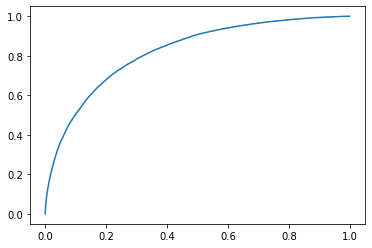

In [42]:
p=lgb.predict_proba(app_train)[:,1]
print(roc_auc_score(app_train_target,p))
fpr,tpr,thr=roc_curve(app_train_target,p)
plt.figure()
plt.plot(fpr,tpr)

In [43]:
output.to_csv("/content/drive/My Drive/FDS/lightgbm.csv", index=False)